In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_interactions import zoom_factory
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
%matplotlib widget

In [11]:
signal_infile_dir = '/sdf/data/neutrino/jvaccaro/SNeNDSens/edepsim/NueArCC'
cosmics_infile_dir = '/sdf/data/neutrino/jvaccaro/CosmicFlux_unprocessed'
BRN_infile_dir = '/sdf/data/neutrino/yuntse/coherent/SNeNDSens/g4/BRN'

segments_dtype = np.dtype([("event_id","u4"), ("vertex_id", "u8"), ("file_vertex_id", "u8"), ("segment_id", "u4"),
                           ("z_end", "f4"),("traj_id", "i4"), ("file_traj_id", "u4"), ("tran_diff", "f4"),
                           ("z_start", "f4"), ("x_end", "f4"),
                           ("y_end", "f4"), ("n_electrons", "u4"),
                           ("pdg_id", "i4"), ("x_start", "f4"),
                           ("y_start", "f4"), ("t_start", "f4"),
                           ("t0_start", "f8"), ("t0_end", "f8"), ("t0", "f8"),
                           ("dx", "f4"), ("long_diff", "f4"),
                           ("pixel_plane", "i4"), ("t_end", "f4"),
                           ("dEdx", "f4"), ("dE2dx", "f4"),
                           ("dE", "f4"), ("dE2", "f4"), ("t", "f4"),
                           ("y", "f4"), ("x", "f4"), ("z", "f4"),
                           ("n_photons","f4")], align=True)

def __binary_search(event_id, arr, i1, i2):
    i = int(np.floor((i2 + i1)/2))
    if (arr[i]['event_id'] == event_id):
        
        while i > 0 and arr[i - 1]['event_id'] == event_id:
            i -= 1
            
        return i

    elif i == 0 or i == (len(arr) - 1) or i1 == i2:
        raise ValueError("Event " + str(event_id) + " not found in list!")
        
    elif arr[i]['event_id'] < event_id:
        return __binary_search(event_id, arr, i + 1, i2)
        
    else:
        return __binary_search(event_id, arr, i1, i - 1)

def loadSignalEvent(file_id, event_id):
    sample = h5py.File(signal_infile_dir + '/nueArCC_sns_g4_' + format(file_id, "04") + '.h5', 'r')
    
    segs = np.array([], dtype=segments_dtype)
    i = __binary_search(event_id, sample['segments'], 0, len(sample['segments']) - 1)
    
    while sample['segments'][i]['event_id'] == event_id:
        segs = np.append(segs, sample['segments'][i])
        i += 1
        
    return segs

def loadCosmicsEvent(file_id, event_id):
    sample = h5py.File(cosmics_infile_dir + '/CosmicFlux_g4_' + format(file_id, "04") + '.h5', 'r')
    
    segs = np.array([], dtype=segments_dtype)
    i = __binary_search(event_id, sample['segments'], 0, len(sample['segments']) - 1)
    
    while sample['segments'][i]['event_id'] == event_id:
        segs = np.append(segs, sample['segments'][i])
        i += 1
        
    return segs

def loadBRNEvent(file_id, event_id):
    sample = h5py.File(BRN_infile_dir + '/BRN_g4_' + format(file_id, "04") + '.h5', 'r')
    
    segs = np.array([], dtype=segments_dtype)
    i = __binary_search(event_id, sample['segments'], 0, len(sample['segments']) - 1)
    
    while sample['segments'][i]['event_id'] == event_id:
        segs = np.append(segs, sample['segments'][i])
        i += 1
        
    return segs

In [12]:
detector_bounds = [[-30, 30], [-25, 25], [-30, 30]] # cm (x, y, z)
def draw_boundaries(ax):
    """
    Draw the detector boundaries as a wireframe
    not needed, but pretty
    """
    boundKwargs = {'color': 'black',
                   'ls': '--'}
    
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)

    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)

    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)

    return ax

def get_color(seg):
    if seg['pdg_id'] == 11:
        return 'b'
    elif seg['pdg_id'] == 22:
        return 'g'
    elif seg['pdg_id'] == 13:
        return 'r'
    elif seg['pdg_id'] == 2212:
        return 'c'
    elif seg['pdg_id'] == 2112:
        return 'm'
    else:
        return 'k'

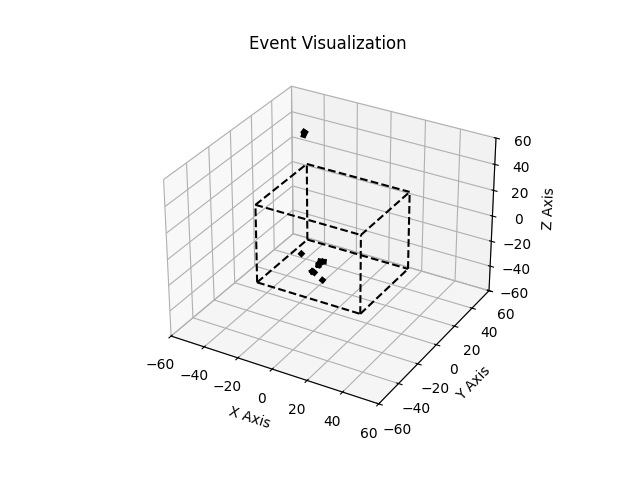

In [13]:
# Load data
data = loadSignalEvent(7, 73930)

# Initialize figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('Event Visualization')

for seg in data:
    ax.plot((seg['x_start'], seg['x_end']), (seg['y_start'], seg['y_end']), (seg['z_start'], seg['z_end']), color='black', linestyle='-', linewidth=4)

# Set limits to reflect detector geometry
draw_boundaries(ax)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Enable scroll to zoom with zoom_factory
disconnect_zoom = zoom_factory(ax, base_scale=1.02)

# Show the plot
plt.show()

Estimated number of clusters: 1
Estimated number of noise points: 13


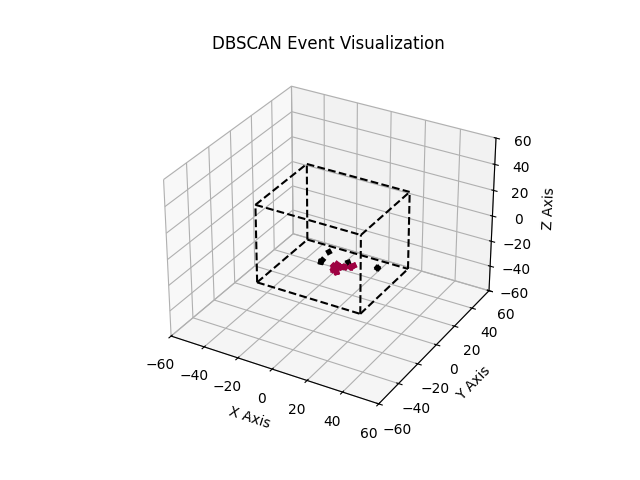

In [9]:
# Load data
data = loadSignalEvent(0, 2)

# Initialize figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('DBSCAN Event Visualization')

# DBSCAN parameters
EPSILON = 8
MIN_SAMPLES = 6
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

db = dbscan.fit([((seg['x_start'] + seg['x_end'])/2, (seg['y_start'] + seg['y_end'])/2, (seg['z_start'] + seg['z_end'])/2) for seg in data])
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for i, seg in enumerate(data):
    if labels[i] == -1:
        col = [0, 0, 0, 1]
    else:
        col = colors[labels[i]]
    ax.plot((seg['x_start'], seg['x_end']), (seg['y_start'], seg['y_end']), (seg['z_start'], seg['z_end']), color=col, linestyle='-', linewidth=4)

# Set limits to reflect detector geometry
draw_boundaries(ax)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Enable scroll to zoom with zoom_factory
disconnect_zoom = zoom_factory(ax, base_scale=1.02)

# Show the plot
plt.show()

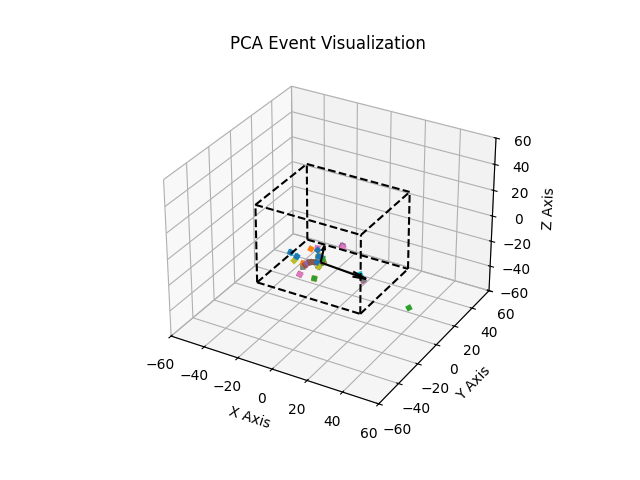

In [6]:
# Load data
data = loadSignalEvent(0, 0)

# Initialize figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA Event Visualization')

# PCA parameters
pca = PCA(n_components=2)
pca.fit([((seg['x_start'] + seg['x_end'])/2, (seg['y_start'] + seg['y_end'])/2, (seg['z_start'] + seg['z_end'])/2) for seg in data])

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2 * np.sqrt(length)
    ax.quiver(pca.mean_[0], pca.mean_[1], pca.mean_[2], v[0], v[1], v[2], color='black')

for seg in data:
    ax.plot((seg['x_start'], seg['x_end']), (seg['y_start'], seg['y_end']), (seg['z_start'], seg['z_end']), linestyle='-', linewidth=4)

# Set limits to reflect detector geometry
draw_boundaries(ax)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Enable scroll to zoom with zoom_factory
disconnect_zoom = zoom_factory(ax, base_scale=1.02)

# Show the plot
plt.show()

Estimated number of clusters: 2
Estimated number of noise points: 9


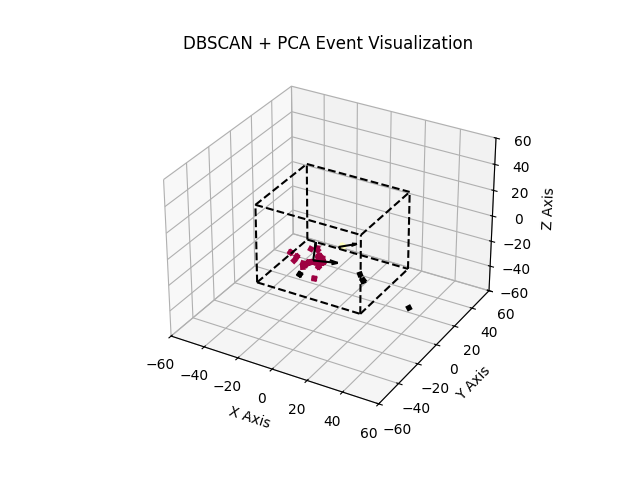

In [7]:
# Load data
data = loadSignalEvent(0, 0)

# Initialize figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('DBSCAN + PCA Event Visualization')

# DBSCAN parameters
EPSILON = 8
MIN_SAMPLES = 6
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

db = dbscan.fit([((seg['x_start'] + seg['x_end'])/2, (seg['y_start'] + seg['y_end'])/2, (seg['z_start'] + seg['z_end'])/2) for seg in data])
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for i, seg in enumerate(data):
    if labels[i] == -1:
        col = [0, 0, 0, 1]
    else:
        col = colors[labels[i]]
    ax.plot((seg['x_start'], seg['x_end']), (seg['y_start'], seg['y_end']), (seg['z_start'], seg['z_end']), color=col, linestyle='-', linewidth=4)

for label in unique_labels:
    if label == -1:
        continue
        
    # Initialize PCA for each cluster
    pca = PCA(n_components=2)
    pca.fit([((seg['x_start'] + seg['x_end'])/2, (seg['y_start'] + seg['y_end'])/2, (seg['z_start'] + seg['z_end'])/2) for seg in data[labels == label]])
    
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        ax.quiver(pca.mean_[0], pca.mean_[1], pca.mean_[2], v[0], v[1], v[2], color='black')

# Set limits to reflect detector geometry
draw_boundaries(ax)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Enable scroll to zoom with zoom_factory
disconnect_zoom = zoom_factory(ax, base_scale=1.02)

# Show the plot
plt.show()